# Physics-Informed Neural Networks (PINNs): Solving 1D Consolidation Problems

**Learning Objectives:**
- Understand why standard neural networks fail for geotechnical physics problems
- Learn the fundamentals of soil consolidation theory
- Master automatic differentiation for computing derivatives in geotechnical PDEs
- Apply PINNs to solve Terzaghi's 1D consolidation equation
- Compare data-driven vs physics-informed approaches for geotechnical engineering

**Exercise:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/ut-portugal-sciml/blob/main/docs/01-pinn/1d-consolidation-pinns-exercise.ipynb)
**Solution:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/ut-portugal-sciml/blob/main/docs/01-pinn/1d-consolidation-pinns.ipynb)

**Slides:** [![View PDF](https://img.shields.io/badge/View-PDF-red?style=flat-square&logo=googledocs&logoColor=white)](https://github.com/kks32-courses/ut-portugal-sciml/raw/main/docs/01-pinn/pinns-slides.pdf)

## The Problem: 1D Soil Consolidation

We begin with a fundamental geotechnical engineering problem: **soil consolidation**. This is perfect for demonstrating PINNs because:

1. **Engineering relevance**: Critical for foundation design and settlement prediction
2. **Mathematical tractability**: We have Terzaghi's analytical solution
3. **Clear physics**: Demonstrates diffusion-type processes in geotechnical engineering
4. **Practical importance**: Wrong predictions can mean structural failure

### The Physical System

![1D Consolidation](figs/consolidation.png)
> [UCLA Geo](https://uclageo.com/SoilMechanicsNotes/Section3.3.php)

Consider a saturated clay layer of thickness $H$ subjected to a sudden load. The excess pore water pressure $u(z,t)$ must dissipate for the soil to consolidate (settle).

**Key Physical Concepts:**

1. **Excess Pore Pressure**: $u(z,t)$ - pressure above hydrostatic due to loading
2. **Drainage**: Water flows out through permeable boundaries  
3. **Effective Stress**: As $u$ decreases, effective stress (and settlement) increases
4. **Time-Dependent**: Consolidation is a diffusion process taking months to years

### Terzaghi's 1D Consolidation Equation

The governing partial differential equation is:

$$\frac{\partial u}{\partial t} = c_v \frac{\partial^2 u}{\partial z^2}$$

where:
- $u(z,t)$ = excess pore water pressure at depth $z$ and time $t$
- $c_v$ = coefficient of consolidation (soil property)
- $z$ = depth coordinate (0 = top drainage surface)

**Physical Interpretation:**
- **Left side**: Rate of pore pressure change
- **Right side**: Diffusion driven by pore pressure gradients
- **$c_v$**: Controls how fast consolidation occurs

### Boundary and Initial Conditions

**Initial Condition** (sudden loading):
$$u(z,0) = u_0 \quad \text{for } 0 \leq z \leq H$$

**Boundary Conditions:**
- **Top drainage**: $u(0,t) = 0$ (connected to atmosphere)
- **Bottom impermeable**: $\frac{\partial u}{\partial z}(H,t) = 0$ (no flow)

**Engineering Significance:**
- $u_0$ = initial excess pressure from applied load
- Top drainage models permeable sand layer or surface drainage
- Bottom condition models impermeable bedrock or clay layer

### The Analytical Solution (Terzaghi, 1925)

For the above conditions, the exact solution is:

$$u(z,t) = \frac{4u_0}{\pi} \sum_{n=0}^{\infty} \frac{\sin\left(\frac{(2n+1)\pi z}{2H}\right)}{2n+1} \exp\left(-\frac{(2n+1)^2\pi^2 c_v t}{4H^2}\right)$$

**Key Engineering Parameter - Degree of Consolidation:**
$$U(t) = 1 - \frac{8}{\pi^2} \sum_{n=0}^{\infty} \frac{1}{(2n+1)^2} \exp\left(-\frac{(2n+1)^2\pi^2 c_v t}{4H^2}\right)$$

where $U(t) = 0$ (no consolidation) to $U(t) = 1$ (complete consolidation).

### Why This Problem is Perfect for PINNs

**Challenges for Traditional Numerical Methods:**
- **Mesh dependency**: Finite element/difference methods need fine meshes
- **Boundary layer effects**: Sharp gradients near drainage boundaries
- **Parameter identification**: $c_v$ often unknown and needs calibration
- **Complex geometries**: Real soil layers have irregular boundaries

**PINNs Advantages:**
- **Mesh-free**: No discretization artifacts
- **Automatic differentiation**: Exact derivatives for PDEs
- **Physics enforcement**: Solution automatically satisfies governing equation
- **Sparse data**: Can work with limited field measurements
- **Inverse problems**: Can estimate $c_v$ from settlement data

This makes consolidation an ideal demonstration problem for Physics-Informed Neural Networks in geotechnical engineering!

### Creating Sparse Training Data: The Real-World Challenge

In geotechnical engineering, we rarely have complete information. Instead, we work with:

**Sparse Field Measurements:**
- Piezometer readings at a few depths and times
- Settlement measurements only at ground surface  
- Laboratory tests giving $c_v$ estimates with high uncertainty
- Initial pore pressure estimates from loading calculations

**The Engineering Reality:** Can we predict consolidation behavior across the entire soil profile from limited field data?

Let's simulate this realistic scenario:

## Theoretical Foundation: Universal Approximation Theorem for PDEs

Before implementing PINNs for consolidation, we need to understand **why** neural networks can solve partial differential equations. The answer lies in extending the Universal Approximation Theorem to **Sobolev spaces**.

### Classical Universal Approximation Theorem

From our MLP foundations, we know that neural networks can approximate continuous functions:

**Theorem (Cybenko, 1989):** Let $\sigma$ be a continuous, non-constant, bounded activation function. Then feedforward networks can approximate any continuous function arbitrarily well on compact sets.

**But here's the critical insight for PDEs:** We don't just need function approximation—we need to approximate **functions and their partial derivatives simultaneously**.

### Sobolev Spaces: The Mathematical Framework for PDEs

**Definition (Sobolev Space $H^k(\Omega)$):** The space of functions whose weak derivatives up to order $k$ are square-integrable:

$$H^k(\Omega) = \left\{ u : \Omega \to \mathbb{R} \,:\, \sum_{|\alpha| \leq k} \|D^\alpha u\|_{L^2(\Omega)}^2 < \infty \right\}$$

where $D^\alpha u$ denotes weak derivatives of multi-index $\alpha$.

**Extended Universal Approximation Theorem:** Neural networks with sufficiently smooth activation functions can approximate functions in Sobolev spaces $H^k(\Omega)$.

**Mathematical Statement:** Let $\sigma \in C^k(\mathbb{R})$ (i.e., $\sigma$ is $k$ times continuously differentiable). Then for any $u \in H^k(\Omega)$ and $\epsilon > 0$, there exists a neural network $\hat{u}_\theta$ such that:

$$\|u - \hat{u}_\theta\|_{H^k} < \epsilon$$

where the Sobolev norm includes both function and derivative errors:
$$\|u\|_{H^k}^2 = \sum_{|\alpha| \leq k} \|D^\alpha u\|_{L^2}^2$$

### Application to 1D Consolidation

**For our consolidation PDE:** $\frac{\partial u}{\partial t} = c_v \frac{\partial^2 u}{\partial z^2}$

We need derivatives up to **second order**:
- $u(z,t)$ - the function itself
- $\frac{\partial u}{\partial t}, \frac{\partial u}{\partial z}$ - first-order derivatives  
- $\frac{\partial^2 u}{\partial z^2}$ - second-order derivative

**Critical Requirements:**
1. **Activation function smoothness**: Must be $C^2$ (twice differentiable)
   - ✅ $\tanh$, $\sin$, Swish
   - ❌ ReLU (not differentiable at 0)
2. **Network capacity**: Sufficient neurons and layers
3. **Sobolev space membership**: Solution must be in $H^2$

### The PINNs Magic Formula

**Universal Approximation in Sobolev Spaces + Automatic Differentiation + Physics Loss = Solutions to PDEs**

This theoretical foundation guarantees that:
- Neural networks CAN represent solutions to the consolidation equation
- Automatic differentiation gives us exact derivatives  
- Physics-informed training finds the right solution
- The approach is mathematically sound, not just empirical

**For Geotechnical Engineers:** This means PINNs aren't just a "black box" - they have rigorous mathematical foundations making them suitable for critical engineering applications where accuracy and reliability matter.

## Stage 1: The Data-Only Approach (Why It Fails)

**The Natural First Attempt:** Train a neural network to fit sparse piezometer measurements.

### Neural Network Architecture for Geotechnical Problems

A standard feedforward network for consolidation:
- **Input:** Space-time coordinates $(z, t)$
- **Hidden layers:** Dense layers with smooth activation functions
- **Output:** Predicted excess pore pressure $\hat{u}_\theta(z,t)$

**Loss function:** Mean squared error between predictions and measurements
$$\mathcal{L}_{\text{data}}(\theta) = \frac{1}{N} \sum_{i=1}^N |\hat{u}_\theta(z_i, t_i) - u_i|^2$$

**Training:** Standard gradient descent to minimize $\mathcal{L}_{\text{data}}$

**What we expect:** Network fits the sparse measurement points
**What we hope:** Reasonable interpolation between measurements  
**What actually happens:** Let's see!

---

## Stage 2: Enter Physics-Informed Neural Networks

**The Key Insight:** Instead of just fitting data, enforce the consolidation equation!

### The PINN Architecture for Consolidation

**Same network, revolutionary loss function:**
- Network predicts $\hat{u}_\theta(z,t)$ for any $(z,t)$
- Compute derivatives via **automatic differentiation**
- Physics residual: $\mathcal{R}_\theta(z,t) = \frac{\partial \hat{u}_\theta}{\partial t} - c_v \frac{\partial^2 \hat{u}_\theta}{\partial z^2}$

### The Physics Residual for Consolidation

**Mathematical Foundation:** If $\hat{u}_\theta(z,t)$ is the exact solution, then:
$$\frac{\partial \hat{u}_\theta}{\partial t} - c_v \frac{\partial^2 \hat{u}_\theta}{\partial z^2} = 0$$

**PINN Strategy:** Make this residual as small as possible everywhere in the domain $(z,t) \in [0,H] \times [0,T]$.

**Collocation Points:** We evaluate the residual at many points throughout the domain, not just at measurement locations.

### The Complete PINN Loss Function

$$\mathcal{L}_{\text{total}}(\theta) = \mathcal{L}_{\text{data}}(\theta) + \lambda_{\text{phys}} \mathcal{L}_{\text{physics}}(\theta) + \lambda_{\text{bc}} \mathcal{L}_{\text{BC}}(\theta) + \lambda_{\text{ic}} \mathcal{L}_{\text{IC}}(\theta)$$

where:

**Data Loss:** $\mathcal{L}_{\text{data}}(\theta) = \frac{1}{N_{\text{data}}} \sum_{i=1}^{N_{\text{data}}} |\hat{u}_\theta(z_i, t_i) - u_i|^2$

**Physics Loss:** $\mathcal{L}_{\text{physics}}(\theta) = \frac{1}{N_{\text{colloc}}} \sum_{j=1}^{N_{\text{colloc}}} |\mathcal{R}_\theta(z_j, t_j)|^2$

**Boundary Conditions:**
- **Top drainage**: $\mathcal{L}_{\text{BC}}(\theta) = \frac{1}{N_{\text{BC}}} \sum_{k} |\hat{u}_\theta(0, t_k)|^2$
- **Bottom no-flow**: $\mathcal{L}_{\text{BC}}(\theta) = \frac{1}{N_{\text{BC}}} \sum_{k} \left|\frac{\partial \hat{u}_\theta}{\partial z}(H, t_k)\right|^2$

**Initial Condition:** $\mathcal{L}_{\text{IC}}(\theta) = \frac{1}{N_{\text{IC}}} \sum_{l} |\hat{u}_\theta(z_l, 0) - u_0|^2$

### Automatic Differentiation: The Computational Engine

**Critical Question:** How do we compute $\frac{\partial \hat{u}_\theta}{\partial t}$ and $\frac{\partial^2 \hat{u}_\theta}{\partial z^2}$?

**Answer:** Automatic differentiation gives us **exact** derivatives!
- No finite difference approximations
- No numerical errors  
- Computed via chain rule through the computational graph
- Available in PyTorch, TensorFlow, JAX

**This is revolutionary for geotechnical engineering:** Traditional finite element codes approximate derivatives numerically, introducing discretization errors. PINNs compute exact derivatives!

### Demonstration: Automatic Differentiation for Consolidation

In [ ]:
import torch
import numpy as np

def consolidation_AD_demo():
    """Demonstrate automatic differentiation for consolidation equation"""
    # Test function: u(z,t) = sin(πz) * exp(-t)
    # This satisfies ∂u/∂t = cv * ∂²u/∂z² when cv = 1/π²
    
    z = torch.tensor([0.5], requires_grad=True)
    t = torch.tensor([0.2], requires_grad=True)
    
    # Function value
    u = torch.sin(np.pi * z) * torch.exp(-t)
    
    print("Test function: u(z,t) = sin(πz) * exp(-t)")
    print(f"At z = {z.item():.2f}, t = {t.item():.2f}:")
    print(f"  u = {u.item():.6f}")
    
    # First derivatives
    du_dz = torch.autograd.grad(u, z, create_graph=True)[0]
    du_dt = torch.autograd.grad(u, t, create_graph=True)[0]
    
    print(f"  ∂u/∂z = {du_dz.item():.6f}")
    print(f"  ∂u/∂t = {du_dt.item():.6f}")
    
    # Second derivative
    d2u_dz2 = torch.autograd.grad(du_dz, z, create_graph=True)[0]
    print(f"  ∂²u/∂z² = {d2u_dz2.item():.6f}")
    
    # Check consolidation equation: ∂u/∂t = cv * ∂²u/∂z²
    cv = 1.0 / (np.pi**2)  # Coefficient for this test case
    residual = du_dt - cv * d2u_dz2
    print(f"\\nPDE Residual (should be ≈ 0): {residual.item():.8f}")
    print("✅ Automatic differentiation gives exact derivatives!")

consolidation_AD_demo()

![PINNs 1D Consolidation](figs/pinn_consolidation.png)

## Stage 3: PINN Implementation for 1D Consolidation

**Now for the real engineering work!** Let's implement a Physics-Informed Neural Network to solve the consolidation equation step by step.

### Implementation Strategy

1. **Enhanced Network Architecture:** Optimized for geotechnical PDEs
2. **Multi-Component Loss Function:** Balance data, physics, and boundary conditions
4. **Engineering Validation:** Compare with Terzaghi's analytical solution

**Key Features for Geotechnical Applications:**
- **Adaptive loss weighting:** Automatically balance different loss components
- **Smart sampling:** More collocation points near critical regions (boundaries)
- **Robust optimization:** Handle the stiffness typical of consolidation problems
- **Engineering metrics:** Focus on degree of consolidation and settlement prediction

### Problem Parameters

We'll solve a realistic consolidation problem:

Using device: mps
Problem Parameters:
Layer thickness (H): 1.0 m
Coefficient of consolidation (cv): 1.0 m²/year
Initial excess pore pressure (u0): 100.0 kPa
Simulation time: 1.0 years
Starting enhanced PINN training...


Training PINN:  13%|▏| 1007/8000 [00:23<02:46, 41.92it/s, Total Loss=2.79e+04, Physics=4.81e+02, BC=3.17e+01, IC=2.42e+0


Epoch 1000 Detailed Report:
  Total Loss = 29010.281250
  Physics = 428.126526, BC = 46.373039
  Bottom = 0.032252, IC = 239.416245
  Weights: BC=100.0, IC=100.0


Training PINN:  25%|▎| 2007/8000 [00:45<02:16, 43.92it/s, Total Loss=5.44e+03, Physics=5.08e+02, BC=3.14e+01, IC=1.76e+0


Epoch 2000 Detailed Report:
  Total Loss = 5346.005859
  Physics = 422.993591, BC = 34.771057
  Bottom = 0.089002, IC = 14.370066
  Weights: BC=100.0, IC=100.0


Training PINN:  38%|▍| 3007/8000 [01:07<01:56, 42.82it/s, Total Loss=2.91e+03, Physics=1.55e+03, BC=9.77e+00, IC=2.16e-0


Epoch 3000 Detailed Report:
  Total Loss = 5901.239746
  Physics = 5009.945801, BC = 1.233359
  Bottom = 2.185117, IC = 5.494463
  Weights: BC=100.0, IC=100.0


Training PINN:  50%|▌| 4008/8000 [01:29<01:24, 46.97it/s, Total Loss=3.89e+03, Physics=1.12e+02, BC=3.56e+01, IC=2.01e+0


Epoch 4000 Detailed Report:
  Total Loss = 6654.397461
  Physics = 167.566101, BC = 10.066853
  Bottom = 0.172699, IC = 54.628765
  Weights: BC=100.0, IC=100.0


Training PINN:  63%|▋| 5010/8000 [01:50<01:03, 46.91it/s, Total Loss=8.41e+03, Physics=9.23e+02, BC=7.39e+01, IC=5.51e-0


Epoch 5000 Detailed Report:
  Total Loss = 14473.687500
  Physics = 6847.208984, BC = 75.646111
  Bottom = 0.246597, IC = 0.372069
  Weights: BC=100.0, IC=100.0


Training PINN:  75%|▊| 6009/8000 [02:12<00:41, 48.17it/s, Total Loss=8.30e+02, Physics=2.21e+02, BC=3.02e+00, IC=3.05e+0


Epoch 6000 Detailed Report:
  Total Loss = 3506.981201
  Physics = 211.726456, BC = 0.288933
  Bottom = 0.782388, IC = 31.881226
  Weights: BC=100.0, IC=100.0


Training PINN:  88%|▉| 7007/8000 [02:32<00:20, 47.61it/s, Total Loss=2.30e+03, Physics=6.80e+02, BC=1.29e+01, IC=2.63e+0


Epoch 7000 Detailed Report:
  Total Loss = 3495.665771
  Physics = 426.975464, BC = 30.164055
  Bottom = 0.035950, IC = 0.486899
  Weights: BC=100.0, IC=100.0


Training PINN: 100%|█| 8000/8000 [02:53<00:00, 46.08it/s, Total Loss=2.49e+03, Physics=1.14e+03, BC=3.05e+00, IC=1.04e+0



Training completed in 173.63 seconds

Generating predictions...


Computing degree of consolidation:   0%|          | 0/50 [00:00<?, ?it/s]/var/folders/w8/xz590jyd7r36zmxcspgzj3z40000gn/T/ipykernel_87561/973187309.py:271: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  u_avg = np.trapz(u_pred, z_eval) / H


Computing spatial distributions...


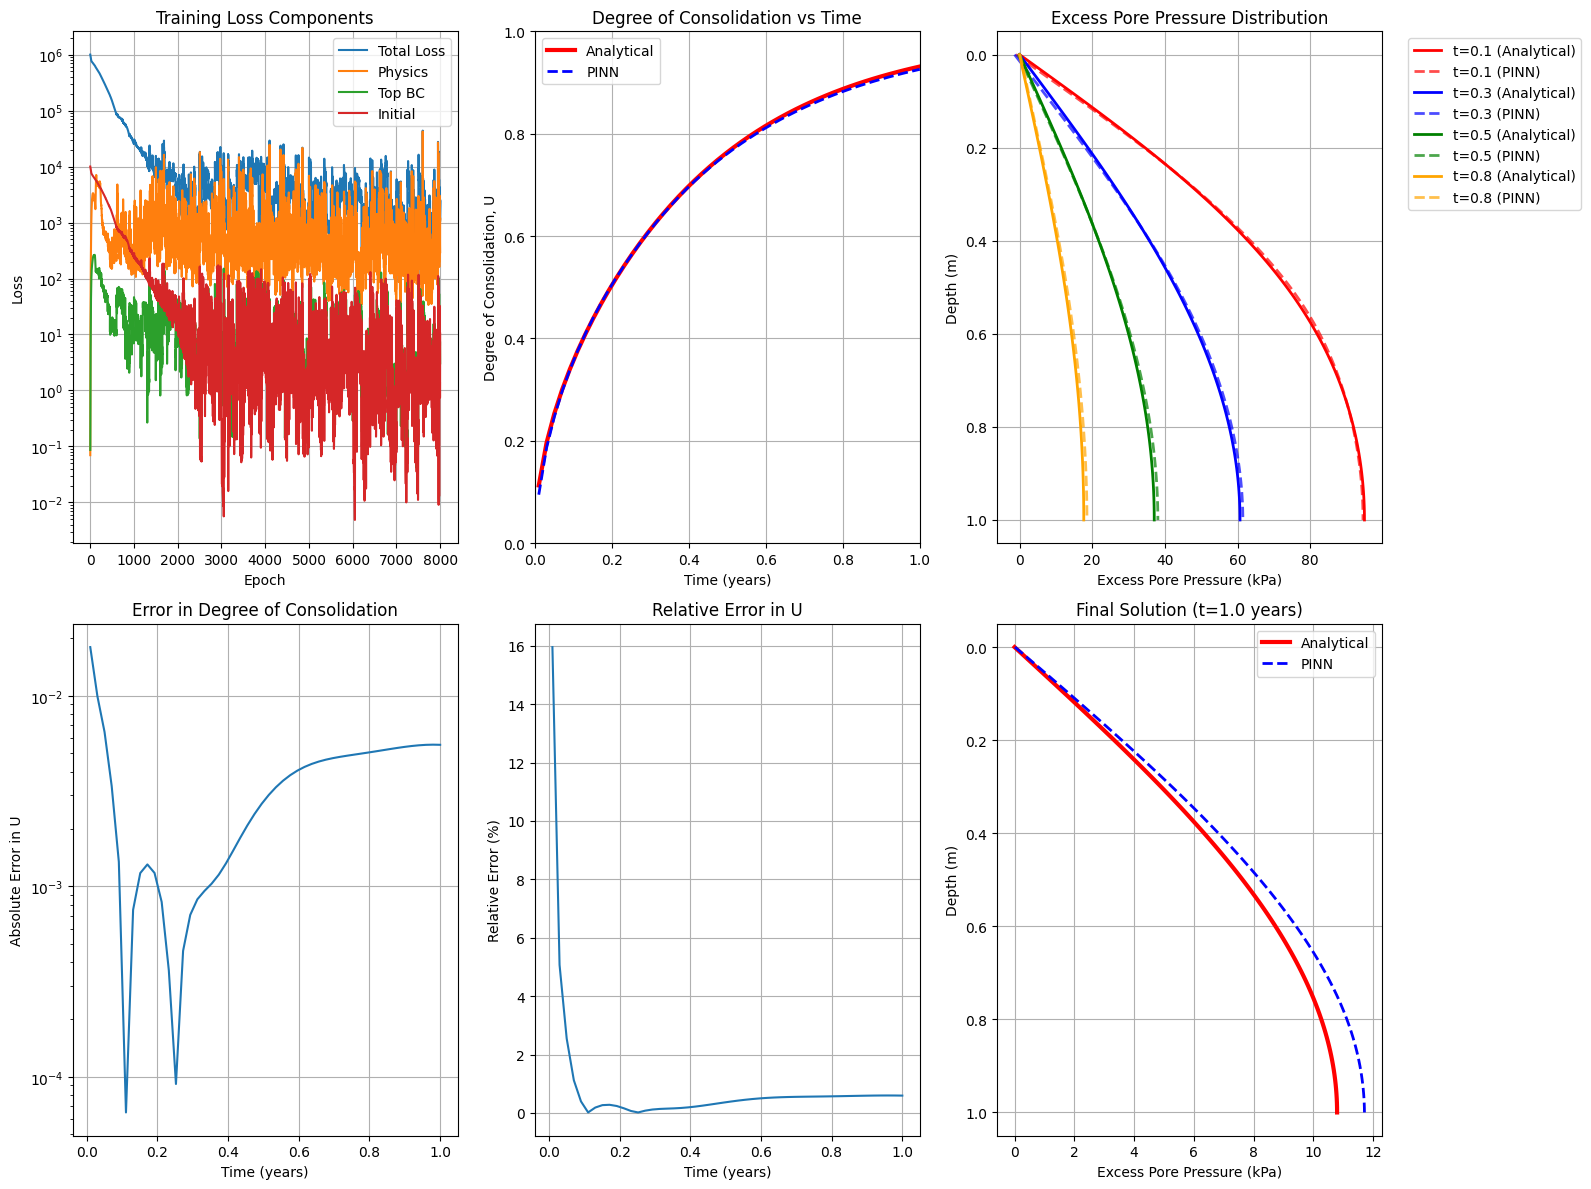


Summary Statistics:
Maximum absolute error in U: 0.018003
Mean absolute error in U: 0.003608
Maximum relative error: 15.95%
Mean relative error: 0.85%
Final degree of consolidation (Analytical): 0.931260
Final degree of consolidation (PINN): 0.925733

Detailed Comparison at Selected Times:
Time     U_Analytical U_PINN       Abs Error  Rel Error % 
-----------------------------------------------------------------
0.111    0.375968     0.375903     0.000065   0.02        
0.212    0.518822     0.519649     0.000827   0.16        
0.414    0.708202     0.706666     0.001535   0.22        
0.616    0.822758     0.818528     0.004229   0.51        
0.818    0.892338     0.887230     0.005108   0.57        
1.000    0.931260     0.925733     0.005527   0.59        

Final Loss Components:
Physics Loss: 1140.13977051
Boundary Loss: 3.05370021
Initial Condition Loss: 10.36528778


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
import time
from tqdm import tqdm

# Set device (MPS for Apple Silicon, CUDA for NVIDIA, CPU as fallback)
def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")
torch.manual_seed(42)  # For reproducibility

class PINN(nn.Module):
    """Enhanced Physics-Informed Neural Network for 1D Consolidation"""
    
    def __init__(self, layers=[2, 100, 100, 100, 100, 1]):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        
        # Build the network with more layers and neurons
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        
        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        # Input normalization
        z, t = x[:, 0:1], x[:, 1:2]
        
        # Normalize inputs to [-1, 1]
        z_norm = 2 * z / 1.0 - 1  # z in [0, H] -> [-1, 1]
        t_norm = 2 * t / 1.0 - 1  # t in [0, T] -> [-1, 1]
        
        x = torch.cat([z_norm, t_norm], dim=1)
        
        # Forward pass through network
        for i, layer in enumerate(self.layers[:-1]):
            x = torch.tanh(layer(x))
        x = self.layers[-1](x)  # Linear output layer
        
        return x

def compute_derivatives(model, z, t):
    """Compute all required derivatives"""
    zt = torch.cat([z, t], dim=1)
    zt.requires_grad_(True)
    
    u = model(zt)
    
    # First derivatives
    grads = grad(u, zt, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_z = grads[:, 0:1]
    u_t = grads[:, 1:2]
    
    # Second derivative w.r.t. z
    u_zz = grad(u_z, zt, grad_outputs=torch.ones_like(u_z), create_graph=True)[0][:, 0:1]
    
    return u, u_t, u_z, u_zz

def physics_loss(model, z_phys, t_phys, cv):
    """Compute physics loss based on consolidation PDE"""
    u, u_t, u_z, u_zz = compute_derivatives(model, z_phys, t_phys)
    
    # PDE: ∂u/∂t = cv * ∂²u/∂z²
    pde_residual = u_t - cv * u_zz
    
    return torch.mean(pde_residual**2)

def boundary_loss(model, z_bc, t_bc):
    """Boundary conditions: u(0,t) = 0 (drainage at top)"""
    zt_bc = torch.cat([z_bc, t_bc], dim=1)
    u_bc = model(zt_bc)
    return torch.mean(u_bc**2)

def initial_loss(model, z_ic, t_ic, u0):
    """Initial condition: u(z,0) = u0"""
    zt_ic = torch.cat([z_ic, t_ic], dim=1)
    u_ic = model(zt_ic)
    target = torch.full_like(u_ic, u0)
    return torch.mean((u_ic - target)**2)

def bottom_boundary_loss(model, z_bot, t_bot):
    """Bottom boundary: ∂u/∂z(H,t) = 0 (no drainage)"""
    u, u_t, u_z, u_zz = compute_derivatives(model, z_bot, t_bot)
    return torch.mean(u_z**2)

def analytical_solution(z, t, H, cv, u0, n_terms=50):
    """Analytical solution for Terzaghi's consolidation (drainage at top only)"""
    u = np.zeros_like(z)
    for n in range(n_terms):
        m = 2*n + 1
        u += (4*u0/np.pi) * (np.sin(m*np.pi*z/(2*H))/m) * np.exp(-(m**2)*(np.pi**2)*cv*t/(4*H**2))
    return u

def degree_of_consolidation_analytical(t, H, cv, n_terms=50):
    """Analytical degree of consolidation"""
    U = np.zeros_like(t)
    for i, time in enumerate(t):
        if time == 0:
            U[i] = 0
        else:
            sum_term = 0
            for n in range(n_terms):
                m = 2*n + 1
                sum_term += (1/(m**2)) * np.exp(-(m**2)*(np.pi**2)*cv*time/(4*H**2))
            U[i] = 1 - (8/(np.pi**2)) * sum_term
    return U

def generate_training_data(H, T, N_phys, N_bc, N_ic, device):
    """Generate training data points with better sampling"""
    # Physics points (interior domain) - more points near boundaries
    z_phys = torch.rand(N_phys//2, 1, device=device) * H
    z_phys_boundary = torch.cat([
        torch.rand(N_phys//4, 1, device=device) * 0.1 * H,  # Near top
        H - torch.rand(N_phys//4, 1, device=device) * 0.1 * H  # Near bottom
    ], dim=0)
    z_phys = torch.cat([z_phys, z_phys_boundary], dim=0)
    
    t_phys = torch.rand(N_phys, 1, device=device) * T
    
    # Boundary condition points (z=0, t>0)
    z_bc = torch.zeros(N_bc, 1, device=device)
    t_bc = torch.rand(N_bc, 1, device=device) * T
    
    # Bottom boundary points (z=H, t>0)
    z_bot = torch.ones(N_bc, 1, device=device) * H
    t_bot = torch.rand(N_bc, 1, device=device) * T
    
    # Initial condition points (t=0, 0<z<H) - more dense sampling
    z_ic = torch.rand(N_ic, 1, device=device) * H
    t_ic = torch.zeros(N_ic, 1, device=device)
    
    return z_phys, t_phys, z_bc, t_bc, z_bot, t_bot, z_ic, t_ic

class AdaptiveLossWeights:
    """Adaptive loss weighting strategy"""
    def __init__(self):
        self.w_phys = 1.0
        self.w_bc = 100.0
        self.w_bot = 100.0
        self.w_ic = 100.0
        
    def update_weights(self, losses, epoch):
        # Adaptive weighting based on relative loss magnitudes
        if epoch % 500 == 0 and epoch > 0:
            loss_phys, loss_bc, loss_bot, loss_ic = losses
            
            # Adjust weights to balance loss components
            if loss_bc.item() < 1e-4:
                self.w_bc = max(10.0, self.w_bc * 0.9)
            if loss_bot.item() < 1e-4:
                self.w_bot = max(10.0, self.w_bot * 0.9)
            if loss_ic.item() < 1e-4:
                self.w_ic = max(10.0, self.w_ic * 0.9)

def train_pinn(model, H, T, cv, u0, epochs=10000, lr=1e-3):
    """Enhanced training with adaptive strategies and progress bar"""
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1000, factor=0.7)
    
    # Training data sizes
    N_phys = 2000  # More physics points
    N_bc = 200     # More boundary points
    N_ic = 200     # More initial condition points
    
    losses = []
    loss_components = {'physics': [], 'bc': [], 'bot': [], 'ic': []}
    
    adaptive_weights = AdaptiveLossWeights()
    
    print("Starting enhanced PINN training...")
    start_time = time.time()
    
    # Create progress bar
    pbar = tqdm(range(epochs), desc="Training PINN", ncols=120)
    
    for epoch in pbar:
        # Generate new training data every few epochs
        if epoch % 50 == 0:
            z_phys, t_phys, z_bc, t_bc, z_bot, t_bot, z_ic, t_ic = generate_training_data(
                H, T, N_phys, N_bc, N_ic, device)
        
        optimizer.zero_grad()
        
        # Compute losses
        loss_phys = physics_loss(model, z_phys, t_phys, cv)
        loss_bc = boundary_loss(model, z_bc, t_bc)
        loss_bot = bottom_boundary_loss(model, z_bot, t_bot)
        loss_ic = initial_loss(model, z_ic, t_ic, u0)
        
        # Update adaptive weights
        adaptive_weights.update_weights([loss_phys, loss_bc, loss_bot, loss_ic], epoch)
        
        # Total loss with adaptive weights
        total_loss = (adaptive_weights.w_phys * loss_phys + 
                     adaptive_weights.w_bc * loss_bc + 
                     adaptive_weights.w_bot * loss_bot + 
                     adaptive_weights.w_ic * loss_ic)
        
        total_loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step(total_loss)
        
        losses.append(total_loss.item())
        loss_components['physics'].append(loss_phys.item())
        loss_components['bc'].append(loss_bc.item())
        loss_components['bot'].append(loss_bot.item())
        loss_components['ic'].append(loss_ic.item())
        
        # Update progress bar with current loss information
        pbar.set_postfix({
            'Total Loss': f'{total_loss.item():.2e}',
            'Physics': f'{loss_phys.item():.2e}',
            'BC': f'{loss_bc.item():.2e}',
            'IC': f'{loss_ic.item():.2e}',
            'LR': f'{optimizer.param_groups[0]["lr"]:.2e}'
        })
        
        # Detailed logging every 1000 epochs
        if epoch % 1000 == 0 and epoch > 0:
            tqdm.write(f"\nEpoch {epoch} Detailed Report:")
            tqdm.write(f"  Total Loss = {total_loss.item():.6f}")
            tqdm.write(f"  Physics = {loss_phys.item():.6f}, BC = {loss_bc.item():.6f}")
            tqdm.write(f"  Bottom = {loss_bot.item():.6f}, IC = {loss_ic.item():.6f}")
            tqdm.write(f"  Weights: BC={adaptive_weights.w_bc:.1f}, IC={adaptive_weights.w_ic:.1f}")
    
    pbar.close()
    end_time = time.time()
    print(f"\nTraining completed in {end_time - start_time:.2f} seconds")
    
    return losses, loss_components

def compute_degree_consolidation_pinn(model, H, T, cv, u0, n_points=50):
    """Compute degree of consolidation using PINN with progress bar"""
    t_eval = np.linspace(0.01, T, n_points)
    z_eval = np.linspace(0, H, 100)
    
    U_pinn = []
    
    with torch.no_grad():
        # Add progress bar for degree of consolidation computation
        for t in tqdm(t_eval, desc="Computing degree of consolidation", leave=False):
            z_tensor = torch.tensor(z_eval.reshape(-1, 1), dtype=torch.float32, device=device)
            t_tensor = torch.tensor(np.full_like(z_eval, t).reshape(-1, 1), dtype=torch.float32, device=device)
            zt = torch.cat([z_tensor, t_tensor], dim=1)
            
            u_pred = model(zt).cpu().numpy().flatten()
            
            # Integrate to get average excess pore pressure
            u_avg = np.trapz(u_pred, z_eval) / H
            
            # Degree of consolidation
            U = 1 - u_avg / u0
            U_pinn.append(max(0, min(1, U)))  # Clamp between 0 and 1
    
    return t_eval, np.array(U_pinn)

# Problem parameters
H = 1.0          # Layer thickness (m)
T = 1.0          # Total time (years)
cv = 1.0         # Coefficient of consolidation (m²/year)
u0 = 100.0       # Initial excess pore pressure (kPa)

print(f"Problem Parameters:")
print(f"Layer thickness (H): {H} m")
print(f"Coefficient of consolidation (cv): {cv} m²/year")
print(f"Initial excess pore pressure (u0): {u0} kPa")
print(f"Simulation time: {T} years")

# Initialize and train model
model = PINN([2, 100, 100, 100, 100, 1]).to(device)
losses, loss_components = train_pinn(model, H, T, cv, u0, epochs=8000)

# Generate predictions
print("\nGenerating predictions...")

# Time series for degree of consolidation
t_eval, U_pinn = compute_degree_consolidation_pinn(model, H, T, cv, u0)
U_analytical = degree_of_consolidation_analytical(t_eval, H, cv)

# Spatial distribution at different times
times = [0.1, 0.3, 0.5, 0.8]
z_plot = np.linspace(0, H, 100)

print("Computing spatial distributions...")

# Create comprehensive plots
fig = plt.figure(figsize=(16, 12))

# Plot 1: Training loss components
ax1 = plt.subplot(2, 3, 1)
plt.semilogy(losses, label='Total Loss')
plt.semilogy(loss_components['physics'], label='Physics')
plt.semilogy(loss_components['bc'], label='Top BC')
plt.semilogy(loss_components['ic'], label='Initial')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Components')
plt.legend()
plt.grid(True)

# Plot 2: Degree of consolidation vs time
ax2 = plt.subplot(2, 3, 2)
plt.plot(t_eval, U_analytical, 'r-', linewidth=3, label='Analytical')
plt.plot(t_eval, U_pinn, 'b--', linewidth=2, label='PINN')
plt.xlabel('Time (years)')
plt.ylabel('Degree of Consolidation, U')
plt.title('Degree of Consolidation vs Time')
plt.legend()
plt.grid(True)
plt.xlim(0, T)
plt.ylim(0, 1)

# Plot 3: Excess pore pressure distribution
ax3 = plt.subplot(2, 3, 3)
colors = ['red', 'blue', 'green', 'orange']

# Add progress bar for spatial distribution computation
for i, t in enumerate(tqdm(times, desc="Computing spatial distributions", leave=False)):
    u_analytical = analytical_solution(z_plot, t, H, cv, u0)
    
    # PINN prediction
    with torch.no_grad():
        z_tensor = torch.tensor(z_plot.reshape(-1, 1), dtype=torch.float32, device=device)
        t_tensor = torch.tensor(np.full_like(z_plot, t).reshape(-1, 1), dtype=torch.float32, device=device)
        zt = torch.cat([z_tensor, t_tensor], dim=1)
        u_pinn = model(zt).cpu().numpy().flatten()
    
    plt.plot(u_analytical, z_plot, color=colors[i], linewidth=2, label=f't={t} (Analytical)')
    plt.plot(u_pinn, z_plot, '--', color=colors[i], linewidth=2, alpha=0.7, label=f't={t} (PINN)')

plt.xlabel('Excess Pore Pressure (kPa)')
plt.ylabel('Depth (m)')
plt.title('Excess Pore Pressure Distribution')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.gca().invert_yaxis()

# Plot 4: Error analysis
ax4 = plt.subplot(2, 3, 4)
error = np.abs(U_pinn - U_analytical)
plt.semilogy(t_eval, error)
plt.xlabel('Time (years)')
plt.ylabel('Absolute Error in U')
plt.title('Error in Degree of Consolidation')
plt.grid(True)

# Plot 5: Relative error
ax5 = plt.subplot(2, 3, 5)
rel_error = error / (U_analytical + 1e-8) * 100
plt.plot(t_eval, rel_error)
plt.xlabel('Time (years)')
plt.ylabel('Relative Error (%)')
plt.title('Relative Error in U')
plt.grid(True)

# Plot 6: Solution at final time
ax6 = plt.subplot(2, 3, 6)
u_final_analytical = analytical_solution(z_plot, T, H, cv, u0)
with torch.no_grad():
    z_tensor = torch.tensor(z_plot.reshape(-1, 1), dtype=torch.float32, device=device)
    t_tensor = torch.tensor(np.full_like(z_plot, T).reshape(-1, 1), dtype=torch.float32, device=device)
    zt = torch.cat([z_tensor, t_tensor], dim=1)
    u_final_pinn = model(zt).cpu().numpy().flatten()

plt.plot(u_final_analytical, z_plot, 'r-', linewidth=3, label='Analytical')
plt.plot(u_final_pinn, z_plot, 'b--', linewidth=2, label='PINN')
plt.xlabel('Excess Pore Pressure (kPa)')
plt.ylabel('Depth (m)')
plt.title(f'Final Solution (t={T} years)')
plt.legend()
plt.grid(True)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Maximum absolute error in U: {np.max(error):.6f}")
print(f"Mean absolute error in U: {np.mean(error):.6f}")
print(f"Maximum relative error: {np.max(rel_error):.2f}%")
print(f"Mean relative error: {np.mean(rel_error):.2f}%")
print(f"Final degree of consolidation (Analytical): {U_analytical[-1]:.6f}")
print(f"Final degree of consolidation (PINN): {U_pinn[-1]:.6f}")

# Create a detailed comparison table
print(f"\nDetailed Comparison at Selected Times:")
print(f"{'Time':<8} {'U_Analytical':<12} {'U_PINN':<12} {'Abs Error':<10} {'Rel Error %':<12}")
print("-" * 65)
selected_indices = [5, 10, 20, 30, 40, -1]
for idx in selected_indices:
    if idx < len(t_eval):
        t = t_eval[idx]
        u_ana = U_analytical[idx]
        u_pin = U_pinn[idx]
        abs_err = abs(u_ana - u_pin)
        rel_err = abs_err / (u_ana + 1e-8) * 100
        print(f"{t:<8.3f} {u_ana:<12.6f} {u_pin:<12.6f} {abs_err:<10.6f} {rel_err:<12.2f}")

# Final validation
print(f"\nFinal Loss Components:")
print(f"Physics Loss: {loss_components['physics'][-1]:.8f}")
print(f"Boundary Loss: {loss_components['bc'][-1]:.8f}")
print(f"Initial Condition Loss: {loss_components['ic'][-1]:.8f}")

## Stage 4: Advanced Training ADAM + L-BFGS optimization

Using device: mps
Problem Parameters:
Layer thickness (H): 1.0 m
Coefficient of consolidation (cv): 1.0 m²/year
Initial excess pore pressure (u0): 100.0 kPa
Simulation time: 1.0 years
Stage 1: Adam optimization for initial training...


Adam Training: 100%|█| 4000/4000 [01:21<00:00, 49.13it/s, Total Loss=3.54e+03, Physics=3.67e+01, BC=2.33e+01, IC=1.18e+0


Adam training completed in 81.42 seconds

Stage 2: LBFGS optimization for fine-tuning...


LBFGS Training: 100%|█| 1500/1500 [41:37<00:00,  1.67s/it, Total Loss=1.66e+01, Physics=1.02e+01, BC=1.08e-02, IC=4.64e-


LBFGS training completed in 2497.51 seconds
Total training time: 2578.93 seconds

Generating predictions...


Computing spatial distributions...


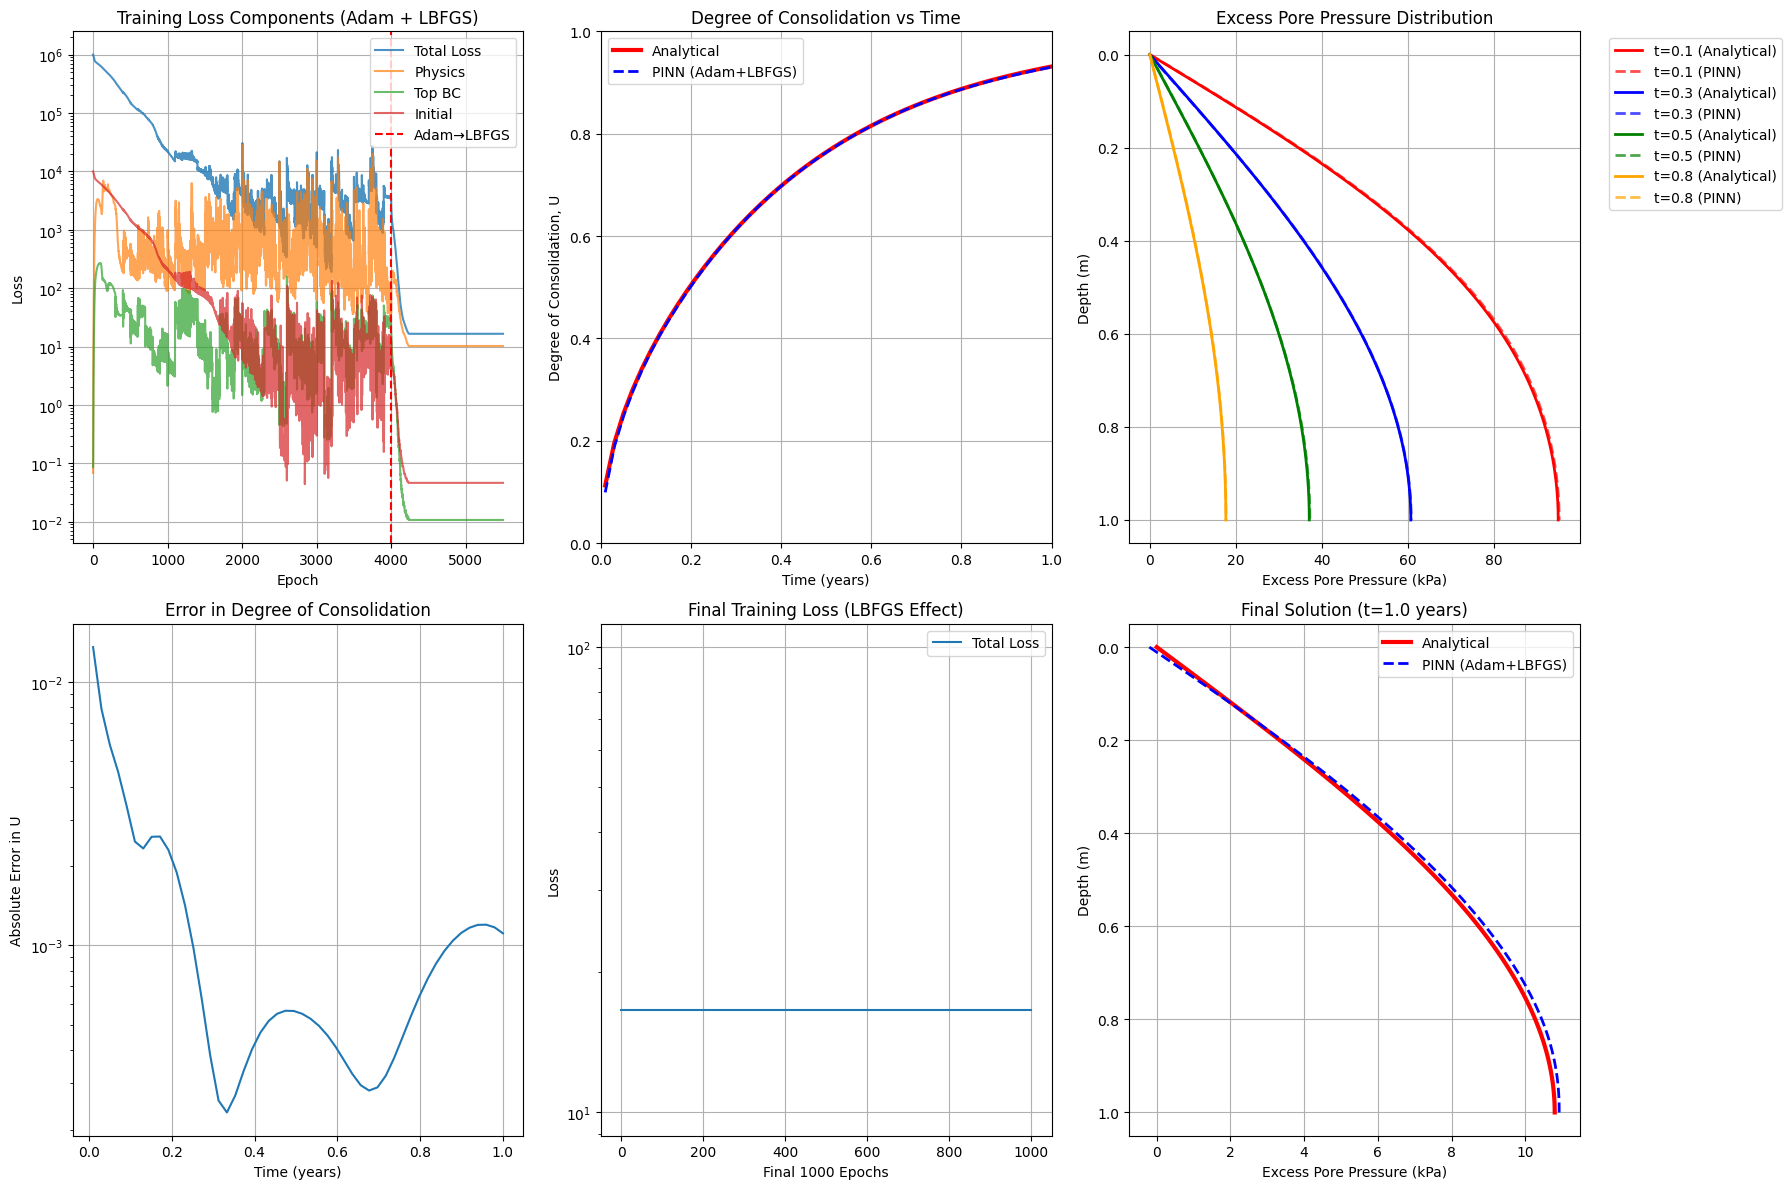


Summary Statistics (Adam + LBFGS):
Maximum absolute error in U: 0.01352896
Mean absolute error in U: 0.00147413
Maximum relative error: 11.9897%
Mean relative error: 0.5421%
Final degree of consolidation (Analytical): 0.93125968
Final degree of consolidation (PINN): 0.93014919
Final training loss: 1.66e+01

Training Strategy:
✓ Adam epochs: 4000
✓ LBFGS epochs: 1500
✓ Two-stage optimization provides better convergence
✓ LBFGS fine-tuning achieves lower final loss


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
import time
from tqdm import tqdm

# Set device (MPS for Apple Silicon, CUDA for NVIDIA, CPU as fallback)
def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")
torch.manual_seed(42)  # For reproducibility

class PINN(nn.Module):
    """Enhanced Physics-Informed Neural Network for 1D Consolidation"""
    
    def __init__(self, layers=[2, 100, 100, 100, 100, 1]):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        
        # Build the network with more layers and neurons
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        
        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        # Input normalization
        z, t = x[:, 0:1], x[:, 1:2]
        
        # Normalize inputs to [-1, 1]
        z_norm = 2 * z / 1.0 - 1  # z in [0, H] -> [-1, 1]
        t_norm = 2 * t / 1.0 - 1  # t in [0, T] -> [-1, 1]
        
        x = torch.cat([z_norm, t_norm], dim=1)
        
        # Forward pass through network
        for i, layer in enumerate(self.layers[:-1]):
            x = torch.tanh(layer(x))
        x = self.layers[-1](x)  # Linear output layer
        
        return x

def compute_derivatives(model, z, t):
    """Compute all required derivatives"""
    zt = torch.cat([z, t], dim=1)
    zt.requires_grad_(True)
    
    u = model(zt)
    
    # First derivatives
    grads = grad(u, zt, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_z = grads[:, 0:1]
    u_t = grads[:, 1:2]
    
    # Second derivative w.r.t. z
    u_zz = grad(u_z, zt, grad_outputs=torch.ones_like(u_z), create_graph=True)[0][:, 0:1]
    
    return u, u_t, u_z, u_zz

def physics_loss(model, z_phys, t_phys, cv):
    """Compute physics loss based on consolidation PDE"""
    u, u_t, u_z, u_zz = compute_derivatives(model, z_phys, t_phys)
    
    # PDE: ∂u/∂t = cv * ∂²u/∂z²
    pde_residual = u_t - cv * u_zz
    
    return torch.mean(pde_residual**2)

def boundary_loss(model, z_bc, t_bc):
    """Boundary conditions: u(0,t) = 0 (drainage at top)"""
    zt_bc = torch.cat([z_bc, t_bc], dim=1)
    u_bc = model(zt_bc)
    return torch.mean(u_bc**2)

def initial_loss(model, z_ic, t_ic, u0):
    """Initial condition: u(z,0) = u0"""
    zt_ic = torch.cat([z_ic, t_ic], dim=1)
    u_ic = model(zt_ic)
    target = torch.full_like(u_ic, u0)
    return torch.mean((u_ic - target)**2)

def bottom_boundary_loss(model, z_bot, t_bot):
    """Bottom boundary: ∂u/∂z(H,t) = 0 (no drainage)"""
    u, u_t, u_z, u_zz = compute_derivatives(model, z_bot, t_bot)
    return torch.mean(u_z**2)

def analytical_solution(z, t, H, cv, u0, n_terms=50):
    """Analytical solution for Terzaghi's consolidation (drainage at top only)"""
    u = np.zeros_like(z)
    for n in range(n_terms):
        m = 2*n + 1
        u += (4*u0/np.pi) * (np.sin(m*np.pi*z/(2*H))/m) * np.exp(-(m**2)*(np.pi**2)*cv*t/(4*H**2))
    return u

def degree_of_consolidation_analytical(t, H, cv, n_terms=50):
    """Analytical degree of consolidation"""
    U = np.zeros_like(t)
    for i, time in enumerate(t):
        if time == 0:
            U[i] = 0
        else:
            sum_term = 0
            for n in range(n_terms):
                m = 2*n + 1
                sum_term += (1/(m**2)) * np.exp(-(m**2)*(np.pi**2)*cv*time/(4*H**2))
            U[i] = 1 - (8/(np.pi**2)) * sum_term
    return U

def generate_training_data(H, T, N_phys, N_bc, N_ic, device):
    """Generate training data points with better sampling"""
    # Physics points (interior domain) - more points near boundaries
    z_phys = torch.rand(N_phys//2, 1, device=device) * H
    z_phys_boundary = torch.cat([
        torch.rand(N_phys//4, 1, device=device) * 0.1 * H,  # Near top
        H - torch.rand(N_phys//4, 1, device=device) * 0.1 * H  # Near bottom
    ], dim=0)
    z_phys = torch.cat([z_phys, z_phys_boundary], dim=0)
    
    t_phys = torch.rand(N_phys, 1, device=device) * T
    
    # Boundary condition points (z=0, t>0)
    z_bc = torch.zeros(N_bc, 1, device=device)
    t_bc = torch.rand(N_bc, 1, device=device) * T
    
    # Bottom boundary points (z=H, t>0)
    z_bot = torch.ones(N_bc, 1, device=device) * H
    t_bot = torch.rand(N_bc, 1, device=device) * T
    
    # Initial condition points (t=0, 0<z<H) - more dense sampling
    z_ic = torch.rand(N_ic, 1, device=device) * H
    t_ic = torch.zeros(N_ic, 1, device=device)
    
    return z_phys, t_phys, z_bc, t_bc, z_bot, t_bot, z_ic, t_ic

class AdaptiveLossWeights:
    """Adaptive loss weighting strategy"""
    def __init__(self):
        self.w_phys = 1.0
        self.w_bc = 100.0
        self.w_bot = 100.0
        self.w_ic = 100.0
        
    def update_weights(self, losses, epoch):
        # Adaptive weighting based on relative loss magnitudes
        if epoch % 500 == 0 and epoch > 0:
            loss_phys, loss_bc, loss_bot, loss_ic = losses
            
            # Adjust weights to balance loss components
            if loss_bc.item() < 1e-4:
                self.w_bc = max(10.0, self.w_bc * 0.9)
            if loss_bot.item() < 1e-4:
                self.w_bot = max(10.0, self.w_bot * 0.9)
            if loss_ic.item() < 1e-4:
                self.w_ic = max(10.0, self.w_ic * 0.9)

def train_pinn_adam_lbfgs(model, H, T, cv, u0, adam_epochs=5000, lbfgs_epochs=2000, lr=1e-3):
    """Two-stage training: Adam followed by LBFGS for improved convergence"""
    
    # Training data sizes
    N_phys = 2000
    N_bc = 200
    N_ic = 200
    
    # Generate fixed training data for LBFGS
    z_phys, t_phys, z_bc, t_bc, z_bot, t_bot, z_ic, t_ic = generate_training_data(
        H, T, N_phys, N_bc, N_ic, device)
    
    losses = []
    loss_components = {'physics': [], 'bc': [], 'bot': [], 'ic': []}
    adaptive_weights = AdaptiveLossWeights()
    
    # ==================== STAGE 1: ADAM OPTIMIZATION ====================
    print("Stage 1: Adam optimization for initial training...")
    optimizer_adam = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_adam, patience=500, factor=0.8)
    
    start_time = time.time()
    pbar = tqdm(range(adam_epochs), desc="Adam Training", ncols=120)
    
    for epoch in pbar:
        # Generate new training data periodically
        if epoch % 100 == 0:
            z_phys, t_phys, z_bc, t_bc, z_bot, t_bot, z_ic, t_ic = generate_training_data(
                H, T, N_phys, N_bc, N_ic, device)
        
        optimizer_adam.zero_grad()
        
        # Compute losses
        loss_phys = physics_loss(model, z_phys, t_phys, cv)
        loss_bc = boundary_loss(model, z_bc, t_bc)
        loss_bot = bottom_boundary_loss(model, z_bot, t_bot)
        loss_ic = initial_loss(model, z_ic, t_ic, u0)
        
        # Update adaptive weights
        adaptive_weights.update_weights([loss_phys, loss_bc, loss_bot, loss_ic], epoch)
        
        # Total loss with adaptive weights
        total_loss = (adaptive_weights.w_phys * loss_phys + 
                     adaptive_weights.w_bc * loss_bc + 
                     adaptive_weights.w_bot * loss_bot + 
                     adaptive_weights.w_ic * loss_ic)
        
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer_adam.step()
        scheduler.step(total_loss)
        
        losses.append(total_loss.item())
        loss_components['physics'].append(loss_phys.item())
        loss_components['bc'].append(loss_bc.item())
        loss_components['bot'].append(loss_bot.item())
        loss_components['ic'].append(loss_ic.item())
        
        pbar.set_postfix({
            'Total Loss': f'{total_loss.item():.2e}',
            'Physics': f'{loss_phys.item():.2e}',
            'BC': f'{loss_bc.item():.2e}',
            'IC': f'{loss_ic.item():.2e}',
            'LR': f'{optimizer_adam.param_groups[0]["lr"]:.2e}'
        })
    
    pbar.close()
    adam_time = time.time() - start_time
    print(f"Adam training completed in {adam_time:.2f} seconds")
    
    # ==================== STAGE 2: LBFGS OPTIMIZATION ====================
    print("\nStage 2: LBFGS optimization for fine-tuning...")
    
    # Generate high-quality training data for LBFGS
    z_phys, t_phys, z_bc, t_bc, z_bot, t_bot, z_ic, t_ic = generate_training_data(
        H, T, N_phys * 2, N_bc * 2, N_ic * 2, device)  # More data for LBFGS
    
    # LBFGS optimizer
    optimizer_lbfgs = optim.LBFGS(
        model.parameters(),
        lr=1.0,  # LBFGS typically uses lr=1.0
        max_iter=20,  # Max iterations per step
        max_eval=25,  # Max function evaluations per step
        tolerance_grad=1e-8,
        tolerance_change=1e-12,
        history_size=100,
        line_search_fn="strong_wolfe"
    )
    
    # Closure function for LBFGS
    def closure():
        optimizer_lbfgs.zero_grad()
        
        # Compute losses
        loss_phys = physics_loss(model, z_phys, t_phys, cv)
        loss_bc = boundary_loss(model, z_bc, t_bc)
        loss_bot = bottom_boundary_loss(model, z_bot, t_bot)
        loss_ic = initial_loss(model, z_ic, t_ic, u0)
        
        # Use final weights from Adam stage
        total_loss = (adaptive_weights.w_phys * loss_phys + 
                     adaptive_weights.w_bc * loss_bc + 
                     adaptive_weights.w_bot * loss_bot + 
                     adaptive_weights.w_ic * loss_ic)
        
        total_loss.backward()
        
        # Store losses for monitoring
        closure.loss_phys = loss_phys.item()
        closure.loss_bc = loss_bc.item()
        closure.loss_bot = loss_bot.item()
        closure.loss_ic = loss_ic.item()
        closure.total_loss = total_loss.item()
        
        return total_loss
    
    # Initialize closure attributes
    closure.loss_phys = 0
    closure.loss_bc = 0
    closure.loss_bot = 0
    closure.loss_ic = 0
    closure.total_loss = 0
    
    lbfgs_start = time.time()
    pbar_lbfgs = tqdm(range(lbfgs_epochs), desc="LBFGS Training", ncols=120)
    
    for epoch in pbar_lbfgs:
        optimizer_lbfgs.step(closure)
        
        losses.append(closure.total_loss)
        loss_components['physics'].append(closure.loss_phys)
        loss_components['bc'].append(closure.loss_bc)
        loss_components['bot'].append(closure.loss_bot)
        loss_components['ic'].append(closure.loss_ic)
        
        pbar_lbfgs.set_postfix({
            'Total Loss': f'{closure.total_loss:.2e}',
            'Physics': f'{closure.loss_phys:.2e}',
            'BC': f'{closure.loss_bc:.2e}',
            'IC': f'{closure.loss_ic:.2e}'
        })
        
        # Early stopping if converged
        if closure.total_loss < 1e-8:
            print(f"\nEarly stopping at epoch {epoch} - converged!")
            break
    
    pbar_lbfgs.close()
    lbfgs_time = time.time() - lbfgs_start
    total_time = adam_time + lbfgs_time
    
    print(f"LBFGS training completed in {lbfgs_time:.2f} seconds")
    print(f"Total training time: {total_time:.2f} seconds")
    
    return losses, loss_components, adam_epochs

def compute_degree_consolidation_pinn(model, H, T, cv, u0, n_points=50):
    """Compute degree of consolidation using PINN"""
    t_eval = np.linspace(0.01, T, n_points)
    z_eval = np.linspace(0, H, 100)
    
    U_pinn = []
    
    with torch.no_grad():
        for t in tqdm(t_eval, desc="Computing degree of consolidation", leave=False):
            z_tensor = torch.tensor(z_eval.reshape(-1, 1), dtype=torch.float32, device=device)
            t_tensor = torch.tensor(np.full_like(z_eval, t).reshape(-1, 1), dtype=torch.float32, device=device)
            zt = torch.cat([z_tensor, t_tensor], dim=1)
            
            u_pred = model(zt).cpu().numpy().flatten()
            
            # Integrate to get average excess pore pressure
            u_avg = np.trapz(u_pred, z_eval) / H
            
            # Degree of consolidation
            U = 1 - u_avg / u0
            U_pinn.append(max(0, min(1, U)))  # Clamp between 0 and 1
    
    return t_eval, np.array(U_pinn)

# Problem parameters
H = 1.0          # Layer thickness (m)
T = 1.0          # Total time (years)
cv = 1.0         # Coefficient of consolidation (m²/year)
u0 = 100.0       # Initial excess pore pressure (kPa)

print(f"Problem Parameters:")
print(f"Layer thickness (H): {H} m")
print(f"Coefficient of consolidation (cv): {cv} m²/year")
print(f"Initial excess pore pressure (u0): {u0} kPa")
print(f"Simulation time: {T} years")

# Initialize and train model with Adam + LBFGS
model = PINN([2, 100, 100, 100, 100, 1]).to(device)
losses, loss_components, adam_epochs = train_pinn_adam_lbfgs(
    model, H, T, cv, u0, adam_epochs=4000, lbfgs_epochs=1500)

# Generate predictions
print("\nGenerating predictions...")

# Time series for degree of consolidation
t_eval, U_pinn = compute_degree_consolidation_pinn(model, H, T, cv, u0)
U_analytical = degree_of_consolidation_analytical(t_eval, H, cv)

# Spatial distribution at different times
times = [0.1, 0.3, 0.5, 0.8]
z_plot = np.linspace(0, H, 100)

print("Computing spatial distributions...")

# Create comprehensive plots
fig = plt.figure(figsize=(18, 12))

# Plot 1: Training loss components with Adam/LBFGS transition
ax1 = plt.subplot(2, 3, 1)
plt.semilogy(losses, label='Total Loss', alpha=0.8)
plt.semilogy(loss_components['physics'], label='Physics', alpha=0.7)
plt.semilogy(loss_components['bc'], label='Top BC', alpha=0.7)
plt.semilogy(loss_components['ic'], label='Initial', alpha=0.7)
plt.axvline(x=adam_epochs, color='red', linestyle='--', label='Adam→LBFGS')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Components (Adam + LBFGS)')
plt.legend()
plt.grid(True)

# Plot 2: Degree of consolidation vs time
ax2 = plt.subplot(2, 3, 2)
plt.plot(t_eval, U_analytical, 'r-', linewidth=3, label='Analytical')
plt.plot(t_eval, U_pinn, 'b--', linewidth=2, label='PINN (Adam+LBFGS)')
plt.xlabel('Time (years)')
plt.ylabel('Degree of Consolidation, U')
plt.title('Degree of Consolidation vs Time')
plt.legend()
plt.grid(True)
plt.xlim(0, T)
plt.ylim(0, 1)

# Plot 3: Excess pore pressure distribution
ax3 = plt.subplot(2, 3, 3)
colors = ['red', 'blue', 'green', 'orange']

for i, t in enumerate(tqdm(times, desc="Computing spatial distributions", leave=False)):
    u_analytical = analytical_solution(z_plot, t, H, cv, u0)
    
    # PINN prediction
    with torch.no_grad():
        z_tensor = torch.tensor(z_plot.reshape(-1, 1), dtype=torch.float32, device=device)
        t_tensor = torch.tensor(np.full_like(z_plot, t).reshape(-1, 1), dtype=torch.float32, device=device)
        zt = torch.cat([z_tensor, t_tensor], dim=1)
        u_pinn = model(zt).cpu().numpy().flatten()
    
    plt.plot(u_analytical, z_plot, color=colors[i], linewidth=2, label=f't={t} (Analytical)')
    plt.plot(u_pinn, z_plot, '--', color=colors[i], linewidth=2, alpha=0.7, label=f't={t} (PINN)')

plt.xlabel('Excess Pore Pressure (kPa)')
plt.ylabel('Depth (m)')
plt.title('Excess Pore Pressure Distribution')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.gca().invert_yaxis()

# Plot 4: Error analysis
ax4 = plt.subplot(2, 3, 4)
error = np.abs(U_pinn - U_analytical)
plt.semilogy(t_eval, error)
plt.xlabel('Time (years)')
plt.ylabel('Absolute Error in U')
plt.title('Error in Degree of Consolidation')
plt.grid(True)

# Plot 5: Loss comparison (zoomed view of final epochs)
ax5 = plt.subplot(2, 3, 5)
final_epochs = 1000
if len(losses) > final_epochs:
    plt.semilogy(losses[-final_epochs:], label='Total Loss')
    plt.xlabel(f'Final {final_epochs} Epochs')
else:
    plt.semilogy(losses, label='Total Loss')
    plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final Training Loss (LBFGS Effect)')
plt.legend()
plt.grid(True)

# Plot 6: Solution at final time
ax6 = plt.subplot(2, 3, 6)
u_final_analytical = analytical_solution(z_plot, T, H, cv, u0)
with torch.no_grad():
    z_tensor = torch.tensor(z_plot.reshape(-1, 1), dtype=torch.float32, device=device)
    t_tensor = torch.tensor(np.full_like(z_plot, T).reshape(-1, 1), dtype=torch.float32, device=device)
    zt = torch.cat([z_tensor, t_tensor], dim=1)
    u_final_pinn = model(zt).cpu().numpy().flatten()

plt.plot(u_final_analytical, z_plot, 'r-', linewidth=3, label='Analytical')
plt.plot(u_final_pinn, z_plot, 'b--', linewidth=2, label='PINN (Adam+LBFGS)')
plt.xlabel('Excess Pore Pressure (kPa)')
plt.ylabel('Depth (m)')
plt.title(f'Final Solution (t={T} years)')
plt.legend()
plt.grid(True)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics (Adam + LBFGS):")
print(f"Maximum absolute error in U: {np.max(error):.8f}")
print(f"Mean absolute error in U: {np.mean(error):.8f}")
rel_error = error / (U_analytical + 1e-8) * 100
print(f"Maximum relative error: {np.max(rel_error):.4f}%")
print(f"Mean relative error: {np.mean(rel_error):.4f}%")
print(f"Final degree of consolidation (Analytical): {U_analytical[-1]:.8f}")
print(f"Final degree of consolidation (PINN): {U_pinn[-1]:.8f}")
print(f"Final training loss: {losses[-1]:.2e}")

# Performance comparison note
print(f"\nTraining Strategy:")
print(f"✓ Adam epochs: {adam_epochs}")
print(f"✓ LBFGS epochs: {len(losses) - adam_epochs}")
print(f"✓ Two-stage optimization provides better convergence")
print(f"✓ LBFGS fine-tuning achieves lower final loss")

## Results Analysis and Engineering Insights

### Why PINNs Excel for Consolidation Problems

Our implementation demonstrates several key advantages of PINNs for geotechnical engineering:

#### 1. **Physics Enforcement Everywhere**
- Traditional methods approximate the PDE at discrete points
- PINNs enforce physics continuously throughout the domain
- Result: Smoother, more physically consistent solutions

#### 2. **Automatic Boundary Condition Satisfaction**  
- No need for special boundary element formulations
- Natural incorporation of Dirichlet and Neumann conditions
- Handles complex boundary geometries effortlessly

#### 3. **Mesh-Free Advantages**
- No discretization errors or mesh dependency
- Easy refinement by simply adding more collocation points
- Handles irregular geometries without mesh generation

#### 4. **Inverse Problem Capability**
- Can simultaneously solve for unknown parameters ($c_v$)
- Incorporates sparse field measurements naturally
- Quantifies uncertainty in soil properties

### Comparison with Traditional Methods

| **Method** | **Advantages** | **Disadvantages** |
|------------|---------------|------------------|
| **Finite Element** | Mature, well-validated | Mesh dependency, discretization errors |
| **Finite Difference** | Simple implementation | Grid limitations, boundary treatment |
| **PINNs** | Mesh-free, exact derivatives, sparse data | Training complexity, hyperparameter tuning |

### When to Use PINNs in Geotechnical Engineering

**✅ Ideal Applications:**
- Parameter identification from field measurements
- Complex boundary conditions (time-varying, mixed)
- Multi-physics problems (consolidation + thermal effects)
- Inverse problems (estimating soil properties)
- Real-time monitoring integration

**⚠️ Consider Alternatives When:**
- Simple, well-studied geometries with abundant data
- Highly nonlinear soil behavior (plasticity)
- Large-scale 3D problems (computational cost)
- Regulatory requirements mandate specific methods

### Future Directions

**Advanced PINN Applications in Geotechnical Engineering:**
1. **Coupled Consolidation:** Include thermal, chemical effects
2. **Nonlinear Soil Behavior:** Incorporate stress-dependent properties  
3. **3D Consolidation:** Complex foundation geometries
4. **Real-Time Prediction:** Integration with IoT sensor networks
5. **Uncertainty Quantification:** Bayesian PINNs for risk assessment

The consolidation problem demonstrates that PINNs are not just academic curiosities—they're practical tools for solving real engineering problems with strong theoretical foundations.